In [1]:
import sys

sys.path.append("../..")
import numpy as np
import tensorflow as tf
from Bio import SeqIO

import tensortree

tensortree.set_backend("tensorflow")

2025-10-10 14:02:58.493431: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760097778.510760 3437345 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760097778.515965 3437345 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760097778.530456 3437345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760097778.530487 3437345 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760097778.530489 3437345 computation_placer.cc:177] computation placer alr

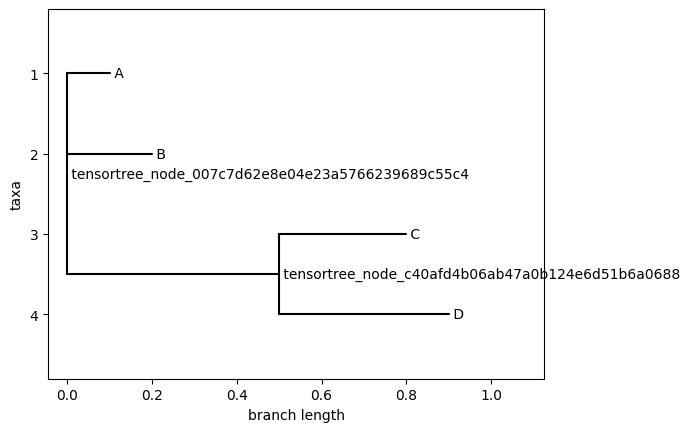

In [3]:
tree_handler = tensortree.TreeHandler.read("../data/simple.tree")
tree_handler.draw()

In [4]:
leaves = [0, 1, 2, 3]

# create an appropriately shaped input tensor
leaves_one_hot = np.eye(4)[leaves]
leaves_one_hot = leaves_one_hot.astype(np.float32)

print(leaves_one_hot)

# add model and width dimensions
leaves_one_hot = leaves_one_hot[:, np.newaxis, np.newaxis]

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [5]:
# use a very simple evolutionary model
R, pi = tensortree.substitution_models.jukes_cantor(4)
Q = tensortree.backend.make_rate_matrix(R, pi)

# add node, model and width dimensions
Q = Q[tf.newaxis, :, tf.newaxis]

Q.shape

I0000 00:00:1760097810.058276 3437345 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13644 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


TensorShape([1, 1, 1, 4, 4])

In [6]:
# compute all transition matrices
transition_probs = tensortree.backend.make_transition_probs(
    Q, tree_handler.branch_lengths[:, :, np.newaxis]
)

# compute the posterior marginals
posterior_marginals = tensortree.model.compute_ancestral_marginals(
    leaves_one_hot,
    tree_handler,
    transition_probs,
    np.log(pi)[np.newaxis, :, np.newaxis],
    return_probabilities=True
).numpy()

I0000 00:00:1760097815.548823 3437345 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x626099f98350


In [7]:
for i in range(tree_handler.num_leaves):
    print("Input at leaf", tree_handler.node_names[i], ":", leaves_one_hot[i, 0, 0])
print("Posterior marginal distribution at E:\n", posterior_marginals[0,0,0])
print("Posterior marginal distribution at F:\n", posterior_marginals[1,0,0])

Input at leaf A : [1. 0. 0. 0.]
Input at leaf B : [0. 1. 0. 0.]
Input at leaf C : [0. 0. 1. 0.]
Input at leaf D : [0. 0. 0. 1.]
Posterior marginal distribution at E:
 [0.15933783 0.09937008 0.42822528 0.31306723]
Posterior marginal distribution at F:
 [0.60789233 0.29487458 0.05354059 0.04369259]
